## Predicting Gym Class Attendance

### 1. Data Preparation and Cleaning

In [141]:
!pip install kaggle

import os
import zipfile
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

!kaggle datasets download ddosad/datacamps-data-science-associate-certification

with zipfile.ZipFile("datacamps-data-science-associate-certification.zip", "r") as zip_ref:
    zip_ref.extractall()

Dataset URL: https://www.kaggle.com/datasets/ddosad/datacamps-data-science-associate-certification
License(s): other
datacamps-data-science-associate-certification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [142]:
df = pd.read_csv("fitness_class_2212.csv")

In [143]:
df.head()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0


In [144]:
df.dtypes

booking_id            int64
months_as_member      int64
weight              float64
days_before          object
day_of_week          object
time                 object
category             object
attended              int64
dtype: object

In [145]:
df.isna().sum()

booking_id           0
months_as_member     0
weight              20
days_before          0
day_of_week          0
time                 0
category             0
attended             0
dtype: int64

#### To replace the missing values in `weight`, it's necessary to explore the distribution of the feature.

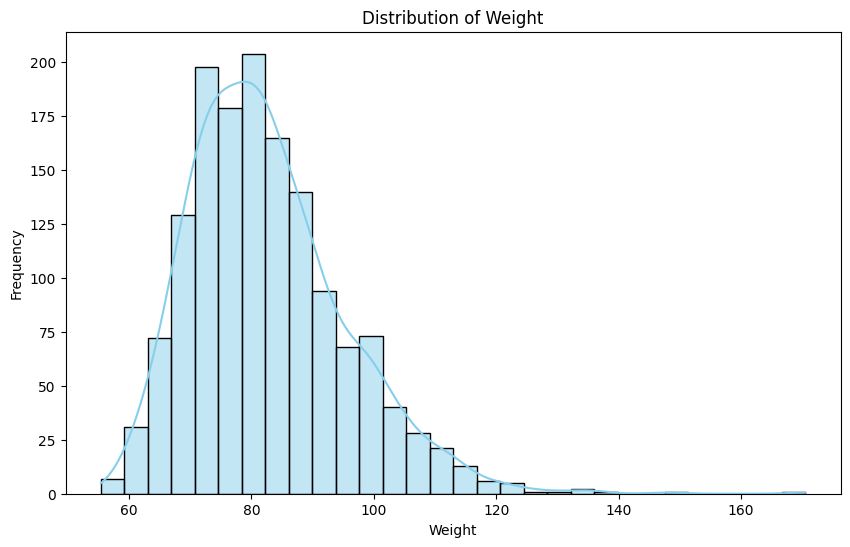

In [146]:
plt.figure(figsize=(10, 6))
sns.histplot(df['weight'], kde=True, bins=30, color='skyblue')  # KDE (Kernel Density Estimation) adds a smooth line
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

#### Since the distribution is right-skewed, it's better to impute the missing values with the `median` since it is not affected by outliers or the long tail of the distribution.

In [147]:
df.weight = df.weight.fillna(df.weight.median())

In [148]:
df.isna().sum()

booking_id          0
months_as_member    0
weight              0
days_before         0
day_of_week         0
time                0
category            0
attended            0
dtype: int64

#### Next, there is a need to delete `booking_id`, convert `days_before` to integers.

In [149]:
df.drop('booking_id', axis=1, inplace=True)

In [150]:
print(df.days_before.unique())
print("---------------------")
print(df.days_before.dtype)

['8' '2' '14' '10' '6' '4' '9' '12' '5' '3' '7' '13' '12 days' '20' '1'
 '15' '6 days' '11' '13 days' '3 days' '16' '1 days' '7 days' '8 days'
 '10 days' '14 days' '17' '5 days' '2 days' '4 days' '29']
---------------------
object


In [151]:
df.days_before = df.days_before.str.replace(r' days$', '', regex=True) # Remove ' days'

In [152]:
df.days_before = pd.to_numeric(df.days_before, errors='coerce').astype(int) # Convert the cleaned values to integers

In [153]:
df.dtypes

months_as_member      int64
weight              float64
days_before           int64
day_of_week          object
time                 object
category             object
attended              int64
dtype: object

#### Then, we need to ensure that all columns have unique values.

In [154]:
unique_values = df.apply(lambda x: x.unique())
print("\nUnique values in each column:")
print(unique_values)


Unique values in each column:
months_as_member    [17, 10, 16, 5, 15, 7, 11, 9, 23, 13, 8, 22, 6...
weight              [79.56, 79.01, 74.53, 86.12, 69.29, 93.33, 88....
days_before         [8, 2, 14, 10, 6, 4, 9, 12, 5, 3, 7, 13, 20, 1...
day_of_week         [Wed, Mon, Sun, Fri, Thu, Wednesday, Fri., Tue...
time                                                         [PM, AM]
category                     [Strength, HIIT, Cycling, Yoga, -, Aqua]
attended                                                       [0, 1]
dtype: object


In [155]:
df.day_of_week = df.day_of_week.replace({'Wednesday': 'Wed', 'Monday': 'Mon'})  # Replace 'Wednesday' with 'Wed'
df.day_of_week = df.day_of_week.str.replace(r'Fri\.$', 'Fri', regex=True)  # Use raw string to remove period from 'Fri.'

df.category = df.category.replace('-', 'Unknown')  # Replace with "Unknown" instead of NaN to prevent information loss

In [156]:
unique_values = df.apply(lambda x: x.unique()) # Get unique values for all columns in the DataFrame

for column, values in unique_values.items():
    print(f"Unique values in '{column}' column:")
    print(values)
    print("-" * 50)  # Just a separator for readability

Unique values in 'months_as_member' column:
[ 17  10  16   5  15   7  11   9  23  13   8  22   6  33  24  14   2  12
  26  28  27   1   3  21  18  19  53  20  34  25  32  73  55   4  35  54
  76  62  42 105  90  29  60  30 107  52  37  38  48  51  40  89  57  36
  44  39  41  47  58  66  45  43  61  50  65  31  97  59  93 148 111  69]
--------------------------------------------------
Unique values in 'weight' column:
[79.56 79.01 74.53 ... 87.38 68.64 94.39]
--------------------------------------------------
Unique values in 'days_before' column:
[ 8  2 14 10  6  4  9 12  5  3  7 13 20  1 15 11 16 17 29]
--------------------------------------------------
Unique values in 'day_of_week' column:
['Wed' 'Mon' 'Sun' 'Fri' 'Thu' 'Tue' 'Sat']
--------------------------------------------------
Unique values in 'time' column:
['PM' 'AM']
--------------------------------------------------
Unique values in 'category' column:
['Strength' 'HIIT' 'Cycling' 'Yoga' 'Unknown' 'Aqua']
-----------------

In [157]:
# Convert values in columns to lowercase
df.day_of_week = df.day_of_week.str.lower()
df.category = df.category.str.lower()
df.time = df.time.str.lower()

In [158]:
variables = ['day_of_week', 'category', 'time']
for v in variables:
    print(f"Unique values in {v} column:", df[v].unique())

Unique values in day_of_week column: ['wed' 'mon' 'sun' 'fri' 'thu' 'tue' 'sat']
Unique values in category column: ['strength' 'hiit' 'cycling' 'yoga' 'unknown' 'aqua']
Unique values in time column: ['pm' 'am']


### 2. Splitting the dataset
 - Performing a 60%/20%/20% splits for training/validation/test datasets respectively

In [159]:
from sklearn.model_selection import train_test_split

In [160]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [161]:
len(df_train), len(df_val), len(df_test)

(900, 300, 300)

In [162]:
df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

,months_as_member,weight,days_before,day_of_week,time,category,attended
0,27,77.39,8,thu,am,strength,1
1,20,60.10,2,mon,am,aqua,0
2,13,73.05,14,sun,pm,hiit,1
3,10,70.61,8,thu,am,hiit,0
4,20,77.02,8,thu,am,yoga,0
...,...,...,...,...,...,...,...
295,12,72.15,10,fri,am,aqua,1
296,10,80.77,8,thu,am,yoga,1
297,15,77.20,10,fri,am,cycling,0
298,16,71.70,14,sun,am,strength,1


In [163]:
y_train = df_train.attended.values
y_val = df_val.attended.values
y_test = df_test.attended.values

In [164]:
del df_train['attended']
del df_val['attended']
del df_test['attended']

### 3. Exploratory Data Analysis
- Looking at the target variable (attended)
- Assigning numerical and categorical variables

In [169]:
df_full_train.attended.value_counts(normalize=True)

attended
0    0.704167
1    0.295833
Name: proportion, dtype: float64

In [170]:
df_full_train.columns

Index(['months_as_member', 'weight', 'days_before', 'day_of_week', 'time',
       'category', 'attended'],
      dtype='object')

In [171]:
df_full_train.dtypes

months_as_member      int64
weight              float64
days_before           int64
day_of_week          object
time                 object
category             object
attended              int64
dtype: object

In [172]:
numerical = ['months_as_member', 'weight', 'days_before']

In [173]:
categorical = ['day_of_week', 'time', 'category']

In [175]:
df_full_train[categorical]

,day_of_week,time,category
73,wed,pm,hiit
701,thu,am,strength
1307,tue,am,hiit
556,mon,am,strength
785,fri,am,strength
...,...,...,...
715,fri,am,cycling
905,fri,pm,strength
1096,fri,am,cycling
235,sat,am,hiit


In [178]:
df_full_train[categorical].nunique()

day_of_week    7
time           2
category       6
dtype: int64

### 4. Feature importance: Mutual information and Correlation
- Mutual information tells us how much we can learn about one variable if we know the value of another. In this project, it's a way to measure the importance of categorical variables. - https://en.wikipedia.org/wiki/Mutual_information
- A correlation coefficient is a numerical measure of some type of linear correlation, meaning a statistical relationship between two variables. https://en.wikipedia.org/wiki/Correlation_coefficient. It's a way to measure the importance of numerical variables.

#### Mutual information

In [204]:
from sklearn.metrics import mutual_info_score

In [205]:
def mutual_info_attended_score(series):
    return mutual_info_score(series, df_full_train.attended)

In [206]:
mi = df_full_train[categorical].apply(mutual_info_attended_score)
mi.sort_values(ascending=False)

day_of_week    0.002950
time           0.001832
category       0.001477
dtype: float64

#### The low values of mutual information score between the categorical variables and the target variable `attended` implies that the day of the week, time of day nor the fitness class category give little insight into whether a member attended the gym or not.

#### Correlation coefficient

In [207]:
df_full_train[numerical].corrwith(df_full_train.attended).abs()

months_as_member    0.495458
weight              0.285607
days_before         0.028191
dtype: float64

#### The positive values of correlation coefficient implies that the likelihood of attendance increases with increase in each of them but at varying levels.
- `months_as_member` has the highest value albeit moderate relationship with attendance.
- As a member's `weight` increases, the likelihood of attendance increases but the relationship is weak.
- The `days_before` has almost no relationship with whether a person attends the gym.

#### Further insights into relationships between the `categorical` and `numerical` variables 

In [208]:
overall_attendance_rate = df_full_train['attended'].mean()
print("Overall attendance rate:", overall_attendance_rate)

Overall attendance rate: 0.29583333333333334


In [209]:
df_full_train[(df_full_train.months_as_member >= 24) & (df_full_train.weight >= 80)].attended.mean()

np.float64(0.6666666666666666)

In [210]:
df_full_train[(df_full_train.months_as_member >= 24) & (df_full_train.weight < 80)].attended.mean()

np.float64(0.7763975155279503)

In [211]:
df_full_train[(df_full_train.months_as_member >= 24) & (df_full_train.time == 'am')].attended.mean()

np.float64(0.7692307692307693)

#### Implication
- Members who have been with the organization for 2 years or more and weigh less than 80 kg have a higher attendance rate (77.6%) than those who weigh 80 kg or more (66.6%), indicating that `weight` might be a factor influencing attendance, and the lighter group appears more likely to attend compared to the heavier group, at least for long-term members.
- The AM session group (time == 'AM') has an attendance rate comparable to the lighter weight group (weight < 80 kg), which suggests that AM sessions might be preferred by certain subgroups of long-term members (perhaps those who are lighter or simply have different preferences for class timing).
- There's also the possibility that weight and time of day interact, so individuals with specific weight groups might prefer certain times of the day.

#### Conclusion
While each of the variables may not have strong relationship with whether a member attends, on their own, there are interesting patterns among the variables.

### 5. Training the models, tuning their performance and selecting the best model